# RNN을 사용한 문장 생성
설명할 부분이 너무 많아서 Velog 주소로 대체한다.
[RNN을 사용한 문장 생성](https://velog.io/@a01152a/RNN%EC%9D%84-%EC%82%AC%EC%9A%A9%ED%95%9C-%EB%AC%B8%EC%9E%A5-%EC%83%9D%EC%84%B1)

## 7.1.2 문장 생성 구현

In [53]:
import sys
sys.path.append('..')
import numpy as np
from common.functions import softmax
from ch06.rnnlm import Rnnlm
from ch06.better_rnnlm import BetterRnnlm

이전에서 구현한 Rnnlm 클래스를 사용하여 RnnlmGen 클래스를 만들어본다.

In [2]:
class RnnlmGen(Rnnlm):
    def generate(self, start_id, skip_ids=None, sample_size=100):
        '''
        start_id 최초로 주는 단어의 ID
        skip_ids 단어 ID의 리스트(ex. [12, 20]) 리스트에 속하는 ID는 샘플링X
        sample_size = 샘플링 단어 수
        '''
        word_ids = [start_id]
        
        x = start_id
        while len(word_ids) < sample_size:
            # predict()는 미니배치 처리를 하므로 입력 x는 2차원 배열이여야 한다.
            x = np.array(x).reshape(1, 1)
            score = self.predict(x)
            p = softmax(score.flatten())
            
            sampled = np.random.choice(len(p), size=1, p=p)
            if (skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))
                
        return word_ids

가중치 초깃값을 사용

In [3]:
from dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = RnnlmGen()
# model.load_params('../Rnnlm.pkl')

# 시작(start) 문자와 건너뜀(skip) 문자 설정
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]

# 문장 생성
word_ids = model.generate(start_id, skip_ids)
# txt가 ID배열을 문장으로 변환해준다.
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print(txt)

you numerous mystery diluted incorrectly plummeted manitoba fully painted usx fend korea powerful realist competition invests breed wellington holidays creativity jail impetus rothschilds aware hitachi suggested real powerhouse wage solicitation climbing collateralized laband begin sequester shape del. rampant optimism serial massive grew employed promotions recommending philosophy reduce resembles interview discovered hearts strengthen rulings marine rare painting automatic act pool shamir bausch introduced 13-week summoned stolen fax panama priced cent envy confessed traders decades grower fabric september testimony beach fate wings policyholders proof blame earn sidewalk turnaround write-off cie four-game variations hoelzer breaks coupon gotten wear j.c. robbed confusion kansas attendance


In [4]:
# ID배열을 문장으로 변환해준다.
' '.join(['you', 'say', 'goodbye'])

'you say goodbye'

가중치 파일을 사용

In [5]:
from dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = RnnlmGen()
model.load_params('./Rnnlm.pkl')

# 시작(start) 문자와 건너뜀(skip) 문자 설정
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]

# 문장 생성
word_ids = model.generate(start_id, skip_ids)
# txt가 ID배열을 문장으로 변환해준다.
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print(txt)

you talks on the institutions ' parent of taxes increases and played buying differ management and ca n't gauge death.
 mr. jones said remains throughout contrast with arby 's state created for navigation mixte 's west stock to make close on confidential medical.
 terms were n't willing to retain or little goals.
 rising by nomura earlier corp. capital closed down from stocks.
 there and japanese companies ' results include a broad corporate investment deficit of tax initially including gnp than led as focuses on west german state financial government data.
 marketers investors want prepaid management


In [32]:
class BetterRnnlmGen(BetterRnnlm):
    def generate(self, start_id, skip_ids=None, sample_size=100):
        word_ids = [start_id]

        x = start_id
        while len(word_ids) < sample_size:
            # predict()는 미니배치 처리를 하므로 입력 x는 2차원 배열이여야 한다.
            x = np.array(x).reshape(1, 1)
            score = self.predict(x)
            p = softmax(score.flatten())
            
            sampled = np.random.choice(len(p), size=1, p=p)
            if (skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))

        return word_ids

    def get_state(self):
        states = []
        for layer in self.lstm_layers:
            states.append((layer.h, layer.c))
        return states

    def set_state(self, states):
        for layer, state in zip(self.lstm_layers, states):
            layer.set_state(*state)

In [33]:
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)


model = BetterRnnlmGen()
model.load_params('./BetterRnnlm.pkl')

# start 문자와 skip 문자 설정
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]
# 문장 생성
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')

print(txt)


model.reset_state()

start_words = 'the meaning of life is'
start_ids = [word_to_id[w] for w in start_words.split(' ')]

for x in start_ids[:-1]:
    x = np.array(x).reshape(1, 1)
    model.predict(x)

word_ids = model.generate(start_ids[-1], skip_ids)
word_ids = start_ids[:-1] + word_ids
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print('-' * 50)
print(txt)

you would pitch attracting die mr. warren says.
 the most part the firm is willing to take he one.
 the jittery difference between china and england of the u.k. finally proved more success in the ec in making the of all free barriers in putting the goods together.
 it would guide the problems where they break a package with greater quality to the west.
 it is n't as much as surprising an american iron trader said.
 stock prices totals compare by a major squeeze in international stock techniques and relatively clear existing stock market volume
--------------------------------------------------
the meaning of life is n't enough to use for this week.
 but mr. brown said for ms. we seek full sales for the petrochemical industry it would grow the additional agency to write a deal even though we 're responsible for their paper of for december.
 mr. lloyd 's machine owner sent the chip after computers sold more competitive concerns than january.
 hong kong 's comfortable of p&g is now a wave

# 7.2 seq2seq

In [34]:
from dataset import sequence

(x_train, t_train), (x_test, t_test) = \
    sequence.load_data('addition.txt', seed=1984)
char_to_id, id_to_char = sequence.get_vocab()
print(char_to_id)
print(x_train.shape, t_train.shape)
print(x_test.shape, t_test.shape)
# (45000, 7) (45000, 5)
# (5000, 7) (5000, 5)

print(x_train[0])
print(t_train[0])
# [ 3 0 2 0 0 11 5 ]
# [ 6 0 11 7 5 ]

print(''.join([id_to_char[c] for c in x_train[0]]))
print(''.join([id_to_char[c] for c in t_train[0]]))
# 71+118
# _189

{'1': 0, '6': 1, '+': 2, '7': 3, '5': 4, ' ': 5, '_': 6, '9': 7, '2': 8, '0': 9, '3': 10, '8': 11, '4': 12}
(45000, 7) (45000, 5)
(5000, 7) (5000, 5)
[ 3  0  2  0  0 11  5]
[ 6  0 11  7  5]
71+118 
_189 


In [24]:
from common import time_layers

class Encoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        # vocab_size 문자 종류 0~9, '+', '공백 문자', '_'
        V, D ,H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        
        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)
        
        self.params = self.embed.params + self.lstm.params
        self.grads = self.embed.grads + self.lstm.grads
        self.hs = None
        
    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        self.hs = hs
        return hs[:, -1, :]
    
    def backward(self, dh):
        dhs = np.zeros_like(self.hs)
        dhs[:, -1, :] = dh
        
        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

In [28]:
class Decoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)
        
        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads
        
    def forward(self, xs, h):
        self.lstm.set_state(h)
        
        out = self.embed.forward(xs)
        out = self.lstm.forward(out)
        score = self.affine.forward(out)
        return score
    
    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        dout = self.lstm.backward(dout)
        dout = self.embed.backward(dout)
        dh = self.lstm.dh
        return dh
    
    def generate(self, h, start_id, sample_size):
        sampled = []
        sample_id = start_id
        self.lstm.set_state(h)
        
        for _ in range(sample_size):
            x = np.array(sample_id).reshape((1, 1))
            out = self.embed.forward(x)
            out = self.lstm.forward(out)
            score = self.affine.forward(out)
            
            sample_id = np.argmax(score.flatten())
            sampled.append(int(sample_id))
        
        return sampled

In [29]:
from common.time_layers import *
from common.base_model import BaseModel

class Seq2seq(BaseModel):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = Decoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()
        
        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads
        
    def forward(self, xs, ts):
        # 입력은 처음부터 마지막 전까지, 출력은 처음 이후부터 마지막까지
        decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]
        h = self.encoder.forward(xs)
        score = self.decoder.forward(decoder_xs, h)
        loss = self.softmax.forward(score, decoder_ts)
        return loss

    def backward(self, dout=1):
        dout = self.softmax.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)
        return dout

    def generate(self, xs, start_id, sample_size):
        h = self.encoder.forward(xs)
        sampled = self.decoder.generate(h, start_id, sample_size)
        return sampled

# 학습 및 평가

In [39]:
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq

# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 반전 여부 설정 =============================================
is_reverse = False  # True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
# ================================================================

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# 일반 혹은 엿보기(Peeky) 설정 =====================================
model = Seq2seq(vocab_size, wordvec_size, hidden_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list_1 = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list_1.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.56
| 에폭 1 |  반복 21 / 351 | 시간 1[s] | 손실 2.53
| 에폭 1 |  반복 41 / 351 | 시간 2[s] | 손실 2.17
| 에폭 1 |  반복 61 / 351 | 시간 4[s] | 손실 1.96
| 에폭 1 |  반복 81 / 351 | 시간 5[s] | 손실 1.92
| 에폭 1 |  반복 101 / 351 | 시간 6[s] | 손실 1.87
| 에폭 1 |  반복 121 / 351 | 시간 8[s] | 손실 1.85
| 에폭 1 |  반복 141 / 351 | 시간 9[s] | 손실 1.83
| 에폭 1 |  반복 161 / 351 | 시간 10[s] | 손실 1.79
| 에폭 1 |  반복 181 / 351 | 시간 12[s] | 손실 1.77
| 에폭 1 |  반복 201 / 351 | 시간 13[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 14[s] | 손실 1.76
| 에폭 1 |  반복 241 / 351 | 시간 16[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 17[s] | 손실 1.76
| 에폭 1 |  반복 281 / 351 | 시간 19[s] | 손실 1.75
| 에폭 1 |  반복 301 / 351 | 시간 20[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 21[s] | 손실 1.75
| 에폭 1 |  반복 341 / 351 | 시간 23[s] | 손실 1.74
Q 77+85  
T 162 
X 100 
---
Q 975+164
T 1139
X 1000
---
Q 582+84 
T 666 
X 1000
---
Q 8+155  
T 163 
X 100 
---
Q 367+55 
T 422 
X 1000
---
Q 600+257
T 857 
X 1000
---
Q 761+292
T 1053
X 1000
---
Q 830+597
T 1427
X 1000
--

| 에폭 8 |  반복 321 / 351 | 시간 20[s] | 손실 1.01
| 에폭 8 |  반복 341 / 351 | 시간 21[s] | 손실 1.00
Q 77+85  
T 162 
X 158 
---
Q 975+164
T 1139
X 1107
---
Q 582+84 
T 666 
X 656 
---
Q 8+155  
T 163 
O 163 
---
Q 367+55 
T 422 
X 430 
---
Q 600+257
T 857 
X 838 
---
Q 761+292
T 1053
X 1009
---
Q 830+597
T 1427
X 1410
---
Q 26+838 
T 864 
X 861 
---
Q 143+93 
T 236 
X 227 
---
검증 정확도 3.560%
| 에폭 9 |  반복 1 / 351 | 시간 0[s] | 손실 0.99
| 에폭 9 |  반복 21 / 351 | 시간 1[s] | 손실 1.01
| 에폭 9 |  반복 41 / 351 | 시간 2[s] | 손실 0.99
| 에폭 9 |  반복 61 / 351 | 시간 4[s] | 손실 0.99
| 에폭 9 |  반복 81 / 351 | 시간 5[s] | 손실 0.99
| 에폭 9 |  반복 101 / 351 | 시간 7[s] | 손실 0.99
| 에폭 9 |  반복 121 / 351 | 시간 8[s] | 손실 1.03
| 에폭 9 |  반복 141 / 351 | 시간 9[s] | 손실 1.01
| 에폭 9 |  반복 161 / 351 | 시간 11[s] | 손실 1.00
| 에폭 9 |  반복 181 / 351 | 시간 12[s] | 손실 0.99
| 에폭 9 |  반복 201 / 351 | 시간 13[s] | 손실 1.02
| 에폭 9 |  반복 221 / 351 | 시간 15[s] | 손실 1.01
| 에폭 9 |  반복 241 / 351 | 시간 16[s] | 손실 0.99
| 에폭 9 |  반복 261 / 351 | 시간 18[s] | 손실 0.98
| 에폭 9 |  반복 281

| 에폭 16 |  반복 101 / 351 | 시간 6[s] | 손실 0.89
| 에폭 16 |  반복 121 / 351 | 시간 8[s] | 손실 0.87
| 에폭 16 |  반복 141 / 351 | 시간 9[s] | 손실 0.88
| 에폭 16 |  반복 161 / 351 | 시간 11[s] | 손실 0.88
| 에폭 16 |  반복 181 / 351 | 시간 12[s] | 손실 0.87
| 에폭 16 |  반복 201 / 351 | 시간 14[s] | 손실 0.84
| 에폭 16 |  반복 221 / 351 | 시간 15[s] | 손실 0.86
| 에폭 16 |  반복 241 / 351 | 시간 16[s] | 손실 0.86
| 에폭 16 |  반복 261 / 351 | 시간 18[s] | 손실 0.91
| 에폭 16 |  반복 281 / 351 | 시간 19[s] | 손실 0.87
| 에폭 16 |  반복 301 / 351 | 시간 21[s] | 손실 0.85
| 에폭 16 |  반복 321 / 351 | 시간 22[s] | 손실 0.87
| 에폭 16 |  반복 341 / 351 | 시간 23[s] | 손실 0.89
Q 77+85  
T 162 
X 164 
---
Q 975+164
T 1139
X 1136
---
Q 582+84 
T 666 
X 676 
---
Q 8+155  
T 163 
X 172 
---
Q 367+55 
T 422 
X 432 
---
Q 600+257
T 857 
X 866 
---
Q 761+292
T 1053
X 1063
---
Q 830+597
T 1427
X 1420
---
Q 26+838 
T 864 
X 852 
---
Q 143+93 
T 236 
X 249 
---
검증 정확도 4.460%
| 에폭 17 |  반복 1 / 351 | 시간 0[s] | 손실 0.91
| 에폭 17 |  반복 21 / 351 | 시간 1[s] | 손실 0.87
| 에폭 17 |  반복 41 / 351 | 시간 2[s] | 손실 0

Q 77+85  
T 162 
O 162 
---
Q 975+164
T 1139
X 1138
---
Q 582+84 
T 666 
O 666 
---
Q 8+155  
T 163 
X 170 
---
Q 367+55 
T 422 
X 427 
---
Q 600+257
T 857 
X 861 
---
Q 761+292
T 1053
X 1063
---
Q 830+597
T 1427
X 1441
---
Q 26+838 
T 864 
X 861 
---
Q 143+93 
T 236 
X 239 
---
검증 정확도 9.220%
| 에폭 24 |  반복 1 / 351 | 시간 0[s] | 손실 0.76
| 에폭 24 |  반복 21 / 351 | 시간 1[s] | 손실 0.80
| 에폭 24 |  반복 41 / 351 | 시간 2[s] | 손실 0.80
| 에폭 24 |  반복 61 / 351 | 시간 4[s] | 손실 0.77
| 에폭 24 |  반복 81 / 351 | 시간 5[s] | 손실 0.78
| 에폭 24 |  반복 101 / 351 | 시간 6[s] | 손실 0.80
| 에폭 24 |  반복 121 / 351 | 시간 7[s] | 손실 0.77
| 에폭 24 |  반복 141 / 351 | 시간 9[s] | 손실 0.78
| 에폭 24 |  반복 161 / 351 | 시간 10[s] | 손실 0.77
| 에폭 24 |  반복 181 / 351 | 시간 11[s] | 손실 0.77
| 에폭 24 |  반복 201 / 351 | 시간 13[s] | 손실 0.81
| 에폭 24 |  반복 221 / 351 | 시간 14[s] | 손실 0.81
| 에폭 24 |  반복 241 / 351 | 시간 15[s] | 손실 0.80
| 에폭 24 |  반복 261 / 351 | 시간 16[s] | 손실 0.82
| 에폭 24 |  반복 281 / 351 | 시간 18[s] | 손실 0.79
| 에폭 24 |  반복 301 / 351 | 시간 19[s] | 손실 0.79


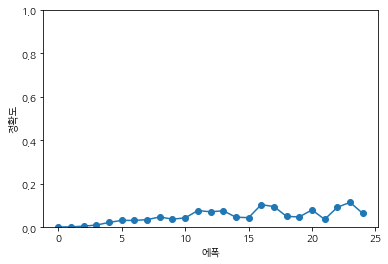

In [40]:
x = np.arange(len(acc_list_1))
plt.plot(x, acc_list_1, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()

# Seq2seq 개선 1- Reverse

In [42]:
# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 반전 여부 설정 =============================================
is_reverse = True  # True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
# ================================================================

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# 일반 혹은 엿보기(Peeky) 설정 =====================================
model = Seq2seq(vocab_size, wordvec_size, hidden_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list_2 = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list_2.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.56
| 에폭 1 |  반복 21 / 351 | 시간 1[s] | 손실 2.52
| 에폭 1 |  반복 41 / 351 | 시간 2[s] | 손실 2.17
| 에폭 1 |  반복 61 / 351 | 시간 3[s] | 손실 1.96
| 에폭 1 |  반복 81 / 351 | 시간 4[s] | 손실 1.91
| 에폭 1 |  반복 101 / 351 | 시간 5[s] | 손실 1.87
| 에폭 1 |  반복 121 / 351 | 시간 6[s] | 손실 1.86
| 에폭 1 |  반복 141 / 351 | 시간 8[s] | 손실 1.84
| 에폭 1 |  반복 161 / 351 | 시간 9[s] | 손실 1.80
| 에폭 1 |  반복 181 / 351 | 시간 10[s] | 손실 1.78
| 에폭 1 |  반복 201 / 351 | 시간 11[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 13[s] | 손실 1.77
| 에폭 1 |  반복 241 / 351 | 시간 15[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 16[s] | 손실 1.75
| 에폭 1 |  반복 281 / 351 | 시간 17[s] | 손실 1.74
| 에폭 1 |  반복 301 / 351 | 시간 19[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 20[s] | 손실 1.74
| 에폭 1 |  반복 341 / 351 | 시간 21[s] | 손실 1.73
Q 77+85  
T 162 
X 100 
---
Q 975+164
T 1139
X 1000
---
Q 582+84 
T 666 
X 1001
---
Q 8+155  
T 163 
X 100 
---
Q 367+55 
T 422 
X 1001
---
Q 600+257
T 857 
X 1000
---
Q 761+292
T 1053
X 1000
---
Q 830+597
T 1427
X 1000
---

| 에폭 8 |  반복 321 / 351 | 시간 20[s] | 손실 0.57
| 에폭 8 |  반복 341 / 351 | 시간 21[s] | 손실 0.57
Q 77+85  
T 162 
X 163 
---
Q 975+164
T 1139
X 1134
---
Q 582+84 
T 666 
O 666 
---
Q 8+155  
T 163 
X 162 
---
Q 367+55 
T 422 
X 423 
---
Q 600+257
T 857 
X 759 
---
Q 761+292
T 1053
O 1053
---
Q 830+597
T 1427
X 1431
---
Q 26+838 
T 864 
X 866 
---
Q 143+93 
T 236 
X 238 
---
검증 정확도 23.080%
| 에폭 9 |  반복 1 / 351 | 시간 0[s] | 손실 0.55
| 에폭 9 |  반복 21 / 351 | 시간 1[s] | 손실 0.56
| 에폭 9 |  반복 41 / 351 | 시간 2[s] | 손실 0.56
| 에폭 9 |  반복 61 / 351 | 시간 3[s] | 손실 0.55
| 에폭 9 |  반복 81 / 351 | 시간 5[s] | 손실 0.54
| 에폭 9 |  반복 101 / 351 | 시간 6[s] | 손실 0.55
| 에폭 9 |  반복 121 / 351 | 시간 7[s] | 손실 0.55
| 에폭 9 |  반복 141 / 351 | 시간 8[s] | 손실 0.54
| 에폭 9 |  반복 161 / 351 | 시간 10[s] | 손실 0.55
| 에폭 9 |  반복 181 / 351 | 시간 11[s] | 손실 0.53
| 에폭 9 |  반복 201 / 351 | 시간 12[s] | 손실 0.54
| 에폭 9 |  반복 221 / 351 | 시간 13[s] | 손실 0.54
| 에폭 9 |  반복 241 / 351 | 시간 14[s] | 손실 0.53
| 에폭 9 |  반복 261 / 351 | 시간 16[s] | 손실 0.53
| 에폭 9 |  반복 28

| 에폭 16 |  반복 101 / 351 | 시간 6[s] | 손실 0.36
| 에폭 16 |  반복 121 / 351 | 시간 8[s] | 손실 0.37
| 에폭 16 |  반복 141 / 351 | 시간 9[s] | 손실 0.36
| 에폭 16 |  반복 161 / 351 | 시간 10[s] | 손실 0.37
| 에폭 16 |  반복 181 / 351 | 시간 12[s] | 손실 0.36
| 에폭 16 |  반복 201 / 351 | 시간 13[s] | 손실 0.38
| 에폭 16 |  반복 221 / 351 | 시간 15[s] | 손실 0.38
| 에폭 16 |  반복 241 / 351 | 시간 16[s] | 손실 0.36
| 에폭 16 |  반복 261 / 351 | 시간 18[s] | 손실 0.35
| 에폭 16 |  반복 281 / 351 | 시간 19[s] | 손실 0.35
| 에폭 16 |  반복 301 / 351 | 시간 21[s] | 손실 0.35
| 에폭 16 |  반복 321 / 351 | 시간 22[s] | 손실 0.35
| 에폭 16 |  반복 341 / 351 | 시간 23[s] | 손실 0.37
Q 77+85  
T 162 
O 162 
---
Q 975+164
T 1139
X 1142
---
Q 582+84 
T 666 
O 666 
---
Q 8+155  
T 163 
O 163 
---
Q 367+55 
T 422 
O 422 
---
Q 600+257
T 857 
X 858 
---
Q 761+292
T 1053
X 1054
---
Q 830+597
T 1427
X 1430
---
Q 26+838 
T 864 
O 864 
---
Q 143+93 
T 236 
X 237 
---
검증 정확도 42.700%
| 에폭 17 |  반복 1 / 351 | 시간 0[s] | 손실 0.34
| 에폭 17 |  반복 21 / 351 | 시간 1[s] | 손실 0.36
| 에폭 17 |  반복 41 / 351 | 시간 2[s] | 손실 

Q 77+85  
T 162 
O 162 
---
Q 975+164
T 1139
X 1142
---
Q 582+84 
T 666 
O 666 
---
Q 8+155  
T 163 
O 163 
---
Q 367+55 
T 422 
O 422 
---
Q 600+257
T 857 
X 858 
---
Q 761+292
T 1053
O 1053
---
Q 830+597
T 1427
X 1429
---
Q 26+838 
T 864 
X 866 
---
Q 143+93 
T 236 
X 238 
---
검증 정확도 45.160%
| 에폭 24 |  반복 1 / 351 | 시간 0[s] | 손실 0.31
| 에폭 24 |  반복 21 / 351 | 시간 1[s] | 손실 0.29
| 에폭 24 |  반복 41 / 351 | 시간 2[s] | 손실 0.28
| 에폭 24 |  반복 61 / 351 | 시간 4[s] | 손실 0.29
| 에폭 24 |  반복 81 / 351 | 시간 5[s] | 손실 0.30
| 에폭 24 |  반복 101 / 351 | 시간 7[s] | 손실 0.29
| 에폭 24 |  반복 121 / 351 | 시간 8[s] | 손실 0.29
| 에폭 24 |  반복 141 / 351 | 시간 10[s] | 손실 0.29
| 에폭 24 |  반복 161 / 351 | 시간 11[s] | 손실 0.28
| 에폭 24 |  반복 181 / 351 | 시간 13[s] | 손실 0.29
| 에폭 24 |  반복 201 / 351 | 시간 14[s] | 손실 0.28
| 에폭 24 |  반복 221 / 351 | 시간 15[s] | 손실 0.28
| 에폭 24 |  반복 241 / 351 | 시간 17[s] | 손실 0.29
| 에폭 24 |  반복 261 / 351 | 시간 18[s] | 손실 0.29
| 에폭 24 |  반복 281 / 351 | 시간 19[s] | 손실 0.29
| 에폭 24 |  반복 301 / 351 | 시간 21[s] | 손실 0.2

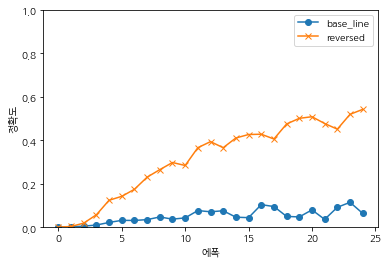

In [47]:
x = np.arange(len(acc_list_2))
plt.plot(x, acc_list_1, marker='o')
plt.plot(x, acc_list_2, marker='x')
plt.legend(['base_line','reverse'])
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()

# Seq2seq 개선 2 - Peeky

In [48]:
class PeekyDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(H + D, 4 * H) / np.sqrt(H + D)).astype('f') # 변화
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H + H, V) / np.sqrt(H + H)).astype('f') # 변화
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads
        self.cache = None

    def forward(self, xs, h):
        N, T = xs.shape
        N, H = h.shape

        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        hs = np.repeat(h, T, axis=0).reshape(N, T, H) # 변화
        out = np.concatenate((hs, out), axis=2) # 변화

        out = self.lstm.forward(out) 
        out = np.concatenate((hs, out), axis=2) # 변화

        score = self.affine.forward(out)
        self.cache = H
        return score

    def backward(self, dscore):
        H = self.cache

        dout = self.affine.backward(dscore)
        dout, dhs0 = dout[:, :, H:], dout[:, :, :H] # 변화 나누기
        dout = self.lstm.backward(dout)
        dembed, dhs1 = dout[:, :, H:], dout[:, :, :H] # 변화 나누기
        self.embed.backward(dembed)

        dhs = dhs0 + dhs1 # 변화
        dh = self.lstm.dh + np.sum(dhs, axis=1) # 변화
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        char_id = start_id
        self.lstm.set_state(h)

        H = h.shape[1]
        peeky_h = h.reshape(1, 1, H)
        for _ in range(sample_size):
            x = np.array([char_id]).reshape((1, 1))
            out = self.embed.forward(x)

            out = np.concatenate((peeky_h, out), axis=2)
            out = self.lstm.forward(out)
            out = np.concatenate((peeky_h, out), axis=2)
            score = self.affine.forward(out)

            char_id = np.argmax(score.flatten())
            sampled.append(char_id)

        return sampled

In [49]:
class PeekySeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = PeekyDecoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

In [50]:
# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 반전 여부 설정 =============================================
is_reverse = True  # True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
# ================================================================

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# 일반 혹은 엿보기(Peeky) 설정 =====================================
#model = Seq2seq(vocab_size, wordvec_size, hidden_size)
model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list_3 = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list_3.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.57
| 에폭 1 |  반복 21 / 351 | 시간 1[s] | 손실 2.48
| 에폭 1 |  반복 41 / 351 | 시간 2[s] | 손실 2.20
| 에폭 1 |  반복 61 / 351 | 시간 3[s] | 손실 1.99
| 에폭 1 |  반복 81 / 351 | 시간 5[s] | 손실 1.89
| 에폭 1 |  반복 101 / 351 | 시간 6[s] | 손실 1.82
| 에폭 1 |  반복 121 / 351 | 시간 7[s] | 손실 1.82
| 에폭 1 |  반복 141 / 351 | 시간 8[s] | 손실 1.80
| 에폭 1 |  반복 161 / 351 | 시간 10[s] | 손실 1.79
| 에폭 1 |  반복 181 / 351 | 시간 11[s] | 손실 1.78
| 에폭 1 |  반복 201 / 351 | 시간 12[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 14[s] | 손실 1.76
| 에폭 1 |  반복 241 / 351 | 시간 15[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 17[s] | 손실 1.75
| 에폭 1 |  반복 281 / 351 | 시간 18[s] | 손실 1.74
| 에폭 1 |  반복 301 / 351 | 시간 20[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 21[s] | 손실 1.73
| 에폭 1 |  반복 341 / 351 | 시간 23[s] | 손실 1.73
Q 77+85  
T 162 
X 100 
---
Q 975+164
T 1139
X 1013
---
Q 582+84 
T 666 
X 102 
---
Q 8+155  
T 163 
X 100 
---
Q 367+55 
T 422 
X 1023
---
Q 600+257
T 857 
X 1023
---
Q 761+292
T 1053
X 1023
---
Q 830+597
T 1427
X 1111
--

| 에폭 8 |  반복 321 / 351 | 시간 23[s] | 손실 0.35
| 에폭 8 |  반복 341 / 351 | 시간 25[s] | 손실 0.34
Q 77+85  
T 162 
X 161 
---
Q 975+164
T 1139
O 1139
---
Q 582+84 
T 666 
X 657 
---
Q 8+155  
T 163 
X 155 
---
Q 367+55 
T 422 
O 422 
---
Q 600+257
T 857 
O 857 
---
Q 761+292
T 1053
O 1053
---
Q 830+597
T 1427
X 1438
---
Q 26+838 
T 864 
O 864 
---
Q 143+93 
T 236 
O 236 
---
검증 정확도 65.060%
| 에폭 9 |  반복 1 / 351 | 시간 0[s] | 손실 0.32
| 에폭 9 |  반복 21 / 351 | 시간 1[s] | 손실 0.31
| 에폭 9 |  반복 41 / 351 | 시간 3[s] | 손실 0.31
| 에폭 9 |  반복 61 / 351 | 시간 4[s] | 손실 0.31
| 에폭 9 |  반복 81 / 351 | 시간 6[s] | 손실 0.29
| 에폭 9 |  반복 101 / 351 | 시간 8[s] | 손실 0.29
| 에폭 9 |  반복 121 / 351 | 시간 9[s] | 손실 0.29
| 에폭 9 |  반복 141 / 351 | 시간 11[s] | 손실 0.27
| 에폭 9 |  반복 161 / 351 | 시간 12[s] | 손실 0.27
| 에폭 9 |  반복 181 / 351 | 시간 14[s] | 손실 0.26
| 에폭 9 |  반복 201 / 351 | 시간 16[s] | 손실 0.25
| 에폭 9 |  반복 221 / 351 | 시간 18[s] | 손실 0.25
| 에폭 9 |  반복 241 / 351 | 시간 20[s] | 손실 0.24
| 에폭 9 |  반복 261 / 351 | 시간 22[s] | 손실 0.24
| 에폭 9 |  반복 2

| 에폭 16 |  반복 101 / 351 | 시간 8[s] | 손실 0.04
| 에폭 16 |  반복 121 / 351 | 시간 9[s] | 손실 0.05
| 에폭 16 |  반복 141 / 351 | 시간 11[s] | 손실 0.05
| 에폭 16 |  반복 161 / 351 | 시간 13[s] | 손실 0.04
| 에폭 16 |  반복 181 / 351 | 시간 14[s] | 손실 0.05
| 에폭 16 |  반복 201 / 351 | 시간 16[s] | 손실 0.04
| 에폭 16 |  반복 221 / 351 | 시간 18[s] | 손실 0.04
| 에폭 16 |  반복 241 / 351 | 시간 20[s] | 손실 0.04
| 에폭 16 |  반복 261 / 351 | 시간 21[s] | 손실 0.04
| 에폭 16 |  반복 281 / 351 | 시간 23[s] | 손실 0.04
| 에폭 16 |  반복 301 / 351 | 시간 25[s] | 손실 0.03
| 에폭 16 |  반복 321 / 351 | 시간 27[s] | 손실 0.03
| 에폭 16 |  반복 341 / 351 | 시간 28[s] | 손실 0.03
Q 77+85  
T 162 
O 162 
---
Q 975+164
T 1139
O 1139
---
Q 582+84 
T 666 
O 666 
---
Q 8+155  
T 163 
O 163 
---
Q 367+55 
T 422 
O 422 
---
Q 600+257
T 857 
O 857 
---
Q 761+292
T 1053
O 1053
---
Q 830+597
T 1427
O 1427
---
Q 26+838 
T 864 
O 864 
---
Q 143+93 
T 236 
O 236 
---
검증 정확도 97.220%
| 에폭 17 |  반복 1 / 351 | 시간 0[s] | 손실 0.03
| 에폭 17 |  반복 21 / 351 | 시간 1[s] | 손실 0.02
| 에폭 17 |  반복 41 / 351 | 시간 2[s] | 손실

Q 77+85  
T 162 
O 162 
---
Q 975+164
T 1139
O 1139
---
Q 582+84 
T 666 
O 666 
---
Q 8+155  
T 163 
O 163 
---
Q 367+55 
T 422 
O 422 
---
Q 600+257
T 857 
O 857 
---
Q 761+292
T 1053
O 1053
---
Q 830+597
T 1427
O 1427
---
Q 26+838 
T 864 
O 864 
---
Q 143+93 
T 236 
O 236 
---
검증 정확도 98.720%
| 에폭 24 |  반복 1 / 351 | 시간 0[s] | 손실 0.01
| 에폭 24 |  반복 21 / 351 | 시간 1[s] | 손실 0.01
| 에폭 24 |  반복 41 / 351 | 시간 3[s] | 손실 0.01
| 에폭 24 |  반복 61 / 351 | 시간 6[s] | 손실 0.01
| 에폭 24 |  반복 81 / 351 | 시간 8[s] | 손실 0.01
| 에폭 24 |  반복 101 / 351 | 시간 10[s] | 손실 0.01
| 에폭 24 |  반복 121 / 351 | 시간 11[s] | 손실 0.01
| 에폭 24 |  반복 141 / 351 | 시간 13[s] | 손실 0.01
| 에폭 24 |  반복 161 / 351 | 시간 15[s] | 손실 0.01
| 에폭 24 |  반복 181 / 351 | 시간 17[s] | 손실 0.01
| 에폭 24 |  반복 201 / 351 | 시간 18[s] | 손실 0.01
| 에폭 24 |  반복 221 / 351 | 시간 20[s] | 손실 0.01
| 에폭 24 |  반복 241 / 351 | 시간 21[s] | 손실 0.01
| 에폭 24 |  반복 261 / 351 | 시간 23[s] | 손실 0.01
| 에폭 24 |  반복 281 / 351 | 시간 24[s] | 손실 0.01
| 에폭 24 |  반복 301 / 351 | 시간 26[s] | 손실 0

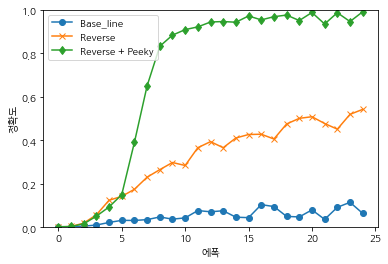

In [52]:
x = np.arange(len(acc_list_2))
plt.plot(x, acc_list_1, marker='o')
plt.plot(x, acc_list_2, marker='x')
plt.plot(x, acc_list_3, marker='d')
plt.legend(['Base_line','Reverse','Reverse + Peeky'])
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()